In [2]:
#Importing the libraries and packages
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
from xgboost import plot_importance
import numpy as np
import sklearn as sk
import imblearn
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import sklearn.datasets as datasets
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from numpy import argmax 
from lightgbm import early_stopping
import copy
from xgboost import XGBClassifier
import xgboost as xgb

# We start the data reading and data processing

In [3]:
#Reading data from data file

df = pd.read_csv("data.csv")
# df.head()     # Checking the entries
# df.shape      #Getting the data on number of entries
# df.Lowest_distortion.value_counts()

In [4]:
#We removed all the theoretically non-exhisting molecules 
# Here we removed entries that had no structure label or data on valence electrons.

df.drop(df.index[(df["Lowest_distortion"] == "-")],axis=0,inplace=True)     
df.drop(df.index[(df["Valence_B"] == "5")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "5")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_B"] == "4")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "4")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_A"] == "element not in BV")],axis=0,inplace=True)
df.drop(df.index[(df["Valence_B"] == "element not in BV")],axis=0,inplace=True)
df.drop(df.index[(df["Vacancy_energy_eV_per_O_atom"] == "-")],axis=0,inplace=True)

# df.Lowest_distortion.value_counts()

In [5]:
# Replacing Strings with integers so that we dont encounter errors in smote
# print(df)


df['Valence_A'] = df['Valence_A'].replace(['not balanced'], '0')    #Replacing not balanced with 0
df['Valence_A'] = df['Valence_A'].replace(['3'], '1')               #Replacing 3 with 1
df['Valence_B'] = df['Valence_B'].replace(['not balanced'], '0')    #Replacing not balanced with 0
df['Valence_B'] = df['Valence_B'].replace(['3'], '1')               #Replacing 3 with 1



df['Lowest_distortion'] = df['Lowest_distortion'].replace(['cubic'], '0')        #Replacing cubic-0,orthorhombic-1,rhombohedral-2,tetragonal-3
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['orthorhombic'], '1')
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['rhombohedral'], '2')
df['Lowest_distortion'] = df['Lowest_distortion'].replace(['tetragonal'], '3')
df['Magnetic_moment_mu_B'] = df['Magnetic_moment_mu_B'].replace(['-'], '0.00')

df['In_literature'] = df['In_literature'].replace([False], '0')   #Replacing False with 0
df['In_literature'] = df['In_literature'].replace([True], '1')    #Replacing True with 1


df.drop(['alpha_deg', 'beta_deg', 'gamma_deg'], axis=1, inplace=True)
df.drop(['a_angs', 'b_angs', 'c_angs'], axis=1, inplace=True)

# print(df)
df[1:]

,Chemical_formula,A,B,In_literature,Valence_A,Valence_B,Radius_A_angs,Radius_B_angs,Lowest_distortion,Formation_energy_eVperatom,Stability_eV_per_atom,Magnetic_moment_mu_B,Volume_per_atom_A_cube_per_atom,Band_gap_eV,Vacancy_energy_eV_per_O_atom
75,AgAlO3,Ag,Al,0,0,0,1.28,0.54,1,-1.510,0.235,0.00,9.898,0.000,-1.341
78,AgBO3,Ag,B,0,1,1,0.75,0.27,0,-0.350,1.074,0.00,8.138,0.000,-2.641
79,AgBaO3,Ag,Ba,0,0,0,1.28,1.35,1,-0.989,0.388,0.00,15.631,0.247,-6.975
80,AgBeO3,Ag,Be,0,0,0,1.28,0.45,0,-0.616,0.683,0.00,8.781,0.000,-3.058
82,AgCaO3,Ag,Ca,0,0,0,1.28,1.00,2,-0.975,0.435,0.00,14.204,0.000,-6.108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,ZrTmO3,Zr,Tm,0,0,0,0.89,0.96,0,-2.315,1.295,0.200,14.496,0.000,-3.645
5325,ZrYO3,Zr,Y,0,0,0,0.89,0.90,0,-2.126,1.422,0.200,15.277,0.000,-4.920
5326,ZrYbO3,Zr,Yb,0,0,0,0.89,0.95,1,-3.455,0.205,0.000,13.136,4.007,-6.177
5327,ZrZnO3,Zr,Zn,0,0,0,0.89,0.74,0,-1.630,1.210,0.001,10.804,0.000,-0.762


In [6]:
#Swapping labels for simplicity.
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
df = df_column_switch(df, "Lowest_distortion", "Vacancy_energy_eV_per_O_atom")
# df.head()

In [7]:
training_data = df.sample(frac=0.8, random_state=25)   #Distributing data set into training and testing dataset
testing_data = df.drop(training_data.index)            # Getting the testing data from dataframe


train_data = training_data.values
X_train = train_data[:, 3:14]
Y_train = train_data[:,14]
# print(X_train)
# print(Y_train)
# print(len(Y_train))
# print(len(X_train))

test_data = testing_data.values
X_test = test_data[:, 3:14]
Y_test = test_data[:,14]
print(Y_train)
# X_test.shape
# Y_test.shape
# X_test.shape

['0' '0' '0' ... '0' '0' '0']


# Applying SMOTE here

Class=0, n=1279 (60.587%)
Class=1, n=688 (32.591%)
Class=2, n=100 (4.737%)
Class=3, n=44 (2.084%)


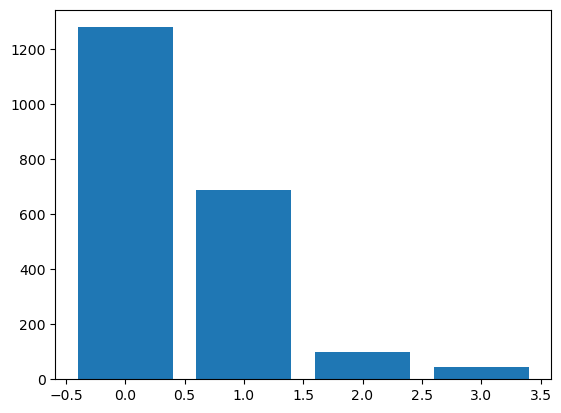

Class=0, n=1279 (25.000%)
Class=1, n=1279 (25.000%)
Class=2, n=1279 (25.000%)
Class=3, n=1279 (25.000%)


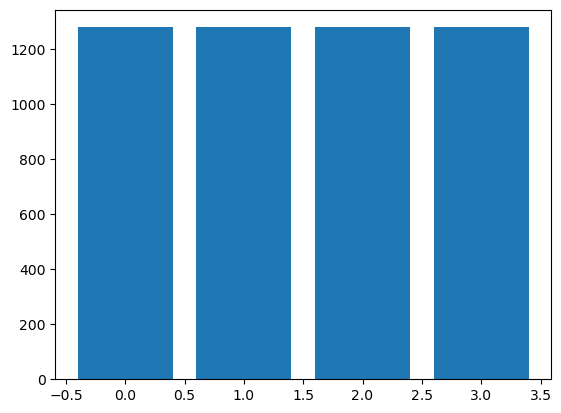

In [8]:
Y_train = LabelEncoder().fit_transform(Y_train)
#Applying SMOTE

# print(len(X_train))
#Showing data imbalance
# print(Y_train)
counter = Counter(Y_train)
for k,v in counter.items():
 per = v / len(Y_train) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()


#Applying SMOTE
oversample = SMOTE()
X_train, Y_train = oversample.fit_resample(X_train, Y_train)


# Summarize distribution after SMOTE
counter = Counter(Y_train)
for k,v in counter.items():
 per = v / len(Y_train) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

# print(X_test)
#Here we oversampled the data with SMOTE ignoring the first 3 columns as they are not important.

# Validation and parameter tuning.

In [9]:
# 'num_leaves': 2

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 2,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.36316
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.34039
[3]	valid_0's multi_logloss: 1.31866
[4]	valid_0's multi_logloss: 1.2979
[5]	valid_0's multi_logloss: 1.27801
[6]	valid_0's multi_logloss: 1.25895
[7]	valid_0's multi_logloss: 1.24064
[8]	valid_0's multi_logloss: 1.22304
[9]	valid_0's multi_logloss: 1.20613
[10]	valid_0's multi_logl

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [10]:
# 'num_leaves': 3

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 3,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.35737
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.32958
[3]	valid_0's multi_logloss: 1.30292
[4]	valid_0's multi_logloss: 1.27762
[5]	valid_0's multi_logloss: 1.25375
[6]	valid_0's multi_logloss: 1.2307
[7]	valid_0's multi_logloss: 1.20847
[8]	valid_0's multi_logloss: 1.18723
[9]	valid_0's multi_logloss: 1.16696
[10]	valid_0's multi_logloss: 1.14781
[11]	valid_0's multi_logloss: 1.12917
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [11]:
# 'num_leaves': 4

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 4,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.35334
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.32155
[3]	valid_0's multi_logloss: 1.29157
[4]	valid_0's multi_logloss: 1.26308
[5]	valid_0's multi_logloss: 1.23611
[6]	valid_0's multi_logloss: 1.21042
[7]	valid_0's multi_logloss: 1.18584
[8]	valid_0's multi_logloss: 1.16265
[9]	valid_0's multi_logloss: 1.1408
[10]	valid_0's multi_logloss: 1.11983
[11]	valid_0's multi_logloss: 1.09936
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [12]:
# 'num_leaves': 5

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 5,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.35125
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.31752
[3]	valid_0's multi_logloss: 1.28569
[4]	valid_0's multi_logloss: 1.25565
[5]	valid_0's multi_logloss: 1.22706
[6]	valid_0's multi_logloss: 1.20018
[7]	valid_0's multi_logloss: 1.1744
[8]	valid_0's multi_logloss: 1.14983
[9]	valid_0's multi_logloss: 1.12657
[10]	valid_0's multi_logloss: 1.10473
[11]	valid_0's multi_logloss: 1.08321
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [13]:
# 'num_leaves': 6

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 6,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.35
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.31503
[3]	valid_0's multi_logloss: 1.28202
[4]	valid_0's multi_logloss: 1.25075
[5]	valid_0's multi_logloss: 1.22128
[6]	valid_0's multi_logloss: 1.19308
[7]	valid_0's multi_logloss: 1.16623
[8]	valid_0's multi_logloss: 1.14109
[9]	valid_0's multi_logloss: 1.11688
[10]	valid_0's multi_logloss: 1.09353
[11]	valid_0's multi_logloss: 1.07197
[12]	valid_0's 

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [14]:
# 'num_leaves': 7

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.3489
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.31304
[3]	valid_0's multi_logloss: 1.27901
[4]	valid_0's multi_logloss: 1.24697
[5]	valid_0's multi_logloss: 1.21665
[6]	valid_0's multi_logloss: 1.18778
[7]	valid_0's multi_logloss: 1.16017
[8]	valid_0's multi_logloss: 1.13397
[9]	valid_0's multi_logloss: 1.10896
[10]	valid_0's multi_logloss: 1.08496
[11]	valid_0's multi_logloss: 1.06184
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [15]:
# 'num_leaves': 8

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 8,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.34771
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.31102
[3]	valid_0's multi_logloss: 1.27555
[4]	valid_0's multi_logloss: 1.24287
[5]	valid_0's multi_logloss: 1.21111
[6]	valid_0's multi_logloss: 1.18162
[7]	valid_0's multi_logloss: 1.15354
[8]	valid_0's multi_logloss: 1.12651
[9]	valid_0's multi_logloss: 1.10045
[10]	valid_0's multi_logloss: 1.07522
[11]	valid_0's multi_logloss: 1.05143
[12]	valid_0

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.83      0.85      0.84       311
           2       0.87      0.82      0.85       302
           3       0.93      0.98      0.96       327

    accuracy                           0.91      1279
   macro avg       0.91      0.91      0.91      1279
weighted avg       0.91      0.91      0.91      1279

[[328   7   3   1]
 [  0 265  31  15]
 [  2  44 249   7]
 [  0   4   2 321]]
Accuracy: 90.93%


In [16]:
# 'num_leaves': 9

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 9,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.3463
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.3086
[3]	valid_0's multi_logloss: 1.27295
[4]	valid_0's multi_logloss: 1.23922
[5]	valid_0's multi_logloss: 1.20662
[6]	valid_0's multi_logloss: 1.17591
[7]	valid_0's multi_logloss: 1.14721
[8]	valid_0's multi_logloss: 1.11938
[9]	valid_0's multi_logloss: 1.09293
[10]	valid_0's multi_logloss: 1.06717
[11]	valid_0's multi_logloss: 1.04279
[12]	valid_0's

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.85      0.86      0.86       311
           2       0.88      0.85      0.87       302
           3       0.94      0.98      0.96       327

    accuracy                           0.92      1279
   macro avg       0.92      0.92      0.92      1279
weighted avg       0.92      0.92      0.92      1279

[[328   7   3   1]
 [  0 269  28  14]
 [  2  38 257   5]
 [  1   2   3 321]]
Accuracy: 91.87%


# Running differerent models, we find that the best accuracy was obtained for num_leaves = 7

In [17]:
# 'learning_rate': 0.01

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.01,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.36789
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.34928
[3]	valid_0's multi_logloss: 1.33125
[4]	valid_0's multi_logloss: 1.3137
[5]	valid_0's multi_logloss: 1.29662
[6]	valid_0's multi_logloss: 1.28002
[7]	valid_0's multi_logloss: 1.2639
[8]	valid_0's multi_logloss: 1.24816
[9]	valid_0's multi_logloss: 1.23285
[10]	valid_0's multi_logloss: 1.21799
[11]	valid_0's multi_logloss: 1.20347
[12]	valid_0's

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [18]:
# 'learning_rate': 0.02

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.02,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.3489
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.31304
[3]	valid_0's multi_logloss: 1.27901
[4]	valid_0's multi_logloss: 1.24697
[5]	valid_0's multi_logloss: 1.21665
[6]	valid_0's multi_logloss: 1.18778
[7]	valid_0's multi_logloss: 1.16017
[8]	valid_0's multi_logloss: 1.13397
[9]	valid_0's multi_logloss: 1.10896
[10]	valid_0's multi_logloss: 1.08496
[11]	valid_0's multi_logloss: 1.06184
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [19]:
# 'learning_rate': 0.03

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.03,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.3301
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.27816
[3]	valid_0's multi_logloss: 1.23019
[4]	valid_0's multi_logloss: 1.18627
[5]	valid_0's multi_logloss: 1.14523
[6]	valid_0's multi_logloss: 1.10718
[7]	valid_0's multi_logloss: 1.07161
[8]	valid_0's multi_logloss: 1.03789
[9]	valid_0's multi_logloss: 1.00742
[10]	valid_0's multi_logloss: 0.977579
[11]	valid_0's multi_logloss: 0.949707
[12]	valid_

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [20]:
# 'learning_rate': 0.04

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.04,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.31149
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.24442
[3]	valid_0's multi_logloss: 1.18448
[4]	valid_0's multi_logloss: 1.13038
[5]	valid_0's multi_logloss: 1.08143
[6]	valid_0's multi_logloss: 1.03635
[7]	valid_0's multi_logloss: 0.994794
[8]	valid_0's multi_logloss: 0.95678
[9]	valid_0's multi_logloss: 0.920933
[10]	valid_0's multi_logloss: 0.889112
[11]	valid_0's multi_logloss: 0.859432
[12]	val

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [21]:
# 'learning_rate': 0.05

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.29308
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.21214
[3]	valid_0's multi_logloss: 1.1418
[4]	valid_0's multi_logloss: 1.07923
[5]	valid_0's multi_logloss: 1.02371
[6]	valid_0's multi_logloss: 0.972596
[7]	valid_0's multi_logloss: 0.927029
[8]	valid_0's multi_logloss: 0.885008
[9]	valid_0's multi_logloss: 0.848484
[10]	valid_0's multi_logloss: 0.813678
[11]	valid_0's multi_logloss: 0.78124
[12]	val

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       1.00      0.96      0.98       339
           1       0.90      0.91      0.91       311
           2       0.93      0.92      0.92       302
           3       0.96      0.99      0.97       327

    accuracy                           0.95      1279
   macro avg       0.95      0.95      0.95      1279
weighted avg       0.95      0.95      0.95      1279

[[327   7   3   2]
 [  0 284  16  11]
 [  0  24 277   1]
 [  0   0   3 324]]
Accuracy: 94.76%


In [22]:
# 'learning_rate': 0.08

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.08,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.23905
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.12287
[3]	valid_0's multi_logloss: 1.02779
[4]	valid_0's multi_logloss: 0.947741
[5]	valid_0's multi_logloss: 0.881324
[6]	valid_0's multi_logloss: 0.821942
[7]	valid_0's multi_logloss: 0.770785
[8]	valid_0's multi_logloss: 0.724588
[9]	valid_0's multi_logloss: 0.681586
[10]	valid_0's multi_logloss: 0.643264
[11]	valid_0's multi_logloss: 0.609484
[12]

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.92      0.93      0.92       311
           2       0.95      0.94      0.95       302
           3       0.97      0.99      0.98       327

    accuracy                           0.96      1279
   macro avg       0.96      0.96      0.96      1279
weighted avg       0.96      0.96      0.96      1279

[[328   7   2   2]
 [  2 289  13   7]
 [  1  16 284   1]
 [  0   2   0 325]]
Accuracy: 95.86%


In [23]:
# 'learning_rate': 0.002

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.002,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.38322
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.37939
[3]	valid_0's multi_logloss: 1.37559
[4]	valid_0's multi_logloss: 1.3718
[5]	valid_0's multi_logloss: 1.36805
[6]	valid_0's multi_logloss: 1.36431
[7]	valid_0's multi_logloss: 1.3606
[8]	valid_0's multi_logloss: 1.35691
[9]	valid_0's multi_logloss: 1.35324
[10]	valid_0's multi_logloss: 1.34959
[11]	valid_0's multi_logloss: 1.34597
[12]	valid_0's

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       339
           1       0.80      0.74      0.77       311
           2       0.82      0.76      0.79       302
           3       0.80      0.93      0.86       327

    accuracy                           0.85      1279
   macro avg       0.85      0.85      0.85      1279
weighted avg       0.86      0.85      0.85      1279

[[325   6   3   5]
 [  1 231  43  36]
 [  1  36 231  34]
 [  0  17   5 305]]
Accuracy: 85.38%


In [24]:
# 'learning_rate': 0.008

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.008,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.37171
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.35672
[3]	valid_0's multi_logloss: 1.34211
[4]	valid_0's multi_logloss: 1.32781
[5]	valid_0's multi_logloss: 1.31386
[6]	valid_0's multi_logloss: 1.30015
[7]	valid_0's multi_logloss: 1.2868
[8]	valid_0's multi_logloss: 1.27375
[9]	valid_0's multi_logloss: 1.26091
[10]	valid_0's multi_logloss: 1.24838
[11]	valid_0's multi_logloss: 1.23613
[12]	valid_0'

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       339
           1       0.78      0.77      0.78       311
           2       0.85      0.74      0.79       302
           3       0.82      0.95      0.88       327

    accuracy                           0.86      1279
   macro avg       0.86      0.86      0.86      1279
weighted avg       0.86      0.86      0.86      1279

[[327   5   3   4]
 [  2 240  36  33]
 [  2  47 224  29]
 [  0  14   2 311]]
Accuracy: 86.16%


In [25]:
# 'learning_rate': 0.009

Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.009,
    'num_class': 4
} 

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
print(len(X_val))
print(len(Y_val))

# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(Xtrain, Ytrain)
lgb_eval = lgb.Dataset(X_val, Y_val, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Ypred = model.predict(X_val)

Ypred = argmax(Ypred, axis=1)
cr = classification_report(Y_val, Ypred)
cm = confusion_matrix(Y_val, Ypred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_val, Ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

1279
1279
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2563
[LightGBM] [Info] Number of data points in the train set: 3837, number of used features: 11
[LightGBM] [Info] Start training from score -1.406566
[LightGBM] [Info] Start training from score -1.377214
[LightGBM] [Info] Start training from score -1.367959
[LightGBM] [Info] Start training from score -1.393881
[1]	valid_0's multi_logloss: 1.3698
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.35299
[3]	valid_0's multi_logloss: 1.33666
[4]	valid_0's multi_logloss: 1.32072
[5]	valid_0's multi_logloss: 1.30521
[6]	valid_0's multi_logloss: 1.29001
[7]	valid_0's multi_logloss: 1.27525
[8]	valid_0's multi_logloss: 1.26081
[9]	valid_0's multi_logloss: 1.24673
[10]	valid_0's multi_logloss: 1.233
[11]	valid_0's multi_logloss: 1.21959
[12]	valid_0's 

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       339
           1       0.80      0.79      0.80       311
           2       0.86      0.75      0.80       302
           3       0.83      0.95      0.89       327

    accuracy                           0.87      1279
   macro avg       0.87      0.87      0.87      1279
weighted avg       0.87      0.87      0.87      1279

[[327   6   3   3]
 [  1 247  33  30]
 [  2  43 228  29]
 [  0  13   2 312]]
Accuracy: 87.10%


# We see that learning rate = 0.08 gives best accuracy and Number of leaves = 7 give best results.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

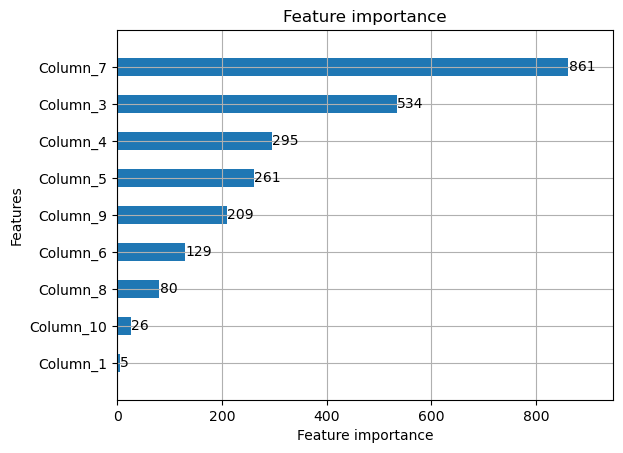

In [26]:
# Here we got importance of features owing to the data
lgb.plot_importance(model, height=.5)

# Implementing LBGM

In [46]:
Ytest = copy.copy(Y_test)
Y_test=[]
# print(Ytest)
for i in Ytest:
    Y_test.append(int(i))
    

# Light GBM :

# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 7,
    'learning_rate': 0.08,
    'num_class': 4
} 


# print(len(X_train),len(Y_train),len(X_test),len(Y_test))
# laoding data
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)
 
# fitting the model
model = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=600)


# prediction
Y_pred = model.predict(X_test)

Y_pred = argmax(Y_pred, axis=1)
cr = classification_report(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
 
print(cr)
print(cm)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

D:\Professional Softwares\Anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 5116, number of used features: 11
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[1]	valid_0's multi_logloss: 1.21251
Training until validation scores don't improve for 600 rounds
[2]	valid_0's multi_logloss: 1.07976
[3]	valid_0's multi_logloss: 0.971688
[4]	valid_0's multi_logloss: 0.880329
[5]	valid_0's multi_logloss: 0.808164
[6]	valid_0's multi_logloss: 0.745515
[7]	valid_0's multi_logloss: 0.687624
[8]	valid_0's multi_logloss: 0.637887
[9]	valid_0's multi_logloss: 0.596427
[10]	valid_0's multi_logloss: 0.555697
[11]	valid_0's multi_logloss: 0.520829
[12]	valid_0'

# XGBoost

In [28]:
# Validation and tuning

Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 10
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.94%


In [29]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 15
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.35%


In [30]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.23%


In [31]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 25
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.71%


In [32]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 30
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.12%


In [33]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 35
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.75%


In [34]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.21,
    'num_class': 4
}
epochs = 40
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.37%


# Epoch = 40 gives best accuracy

In [35]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 2,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.86%


In [36]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 1,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.11%


In [37]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 5,
    'eta': 1.25,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.50%


In [38]:
Xtrain, X_val, Ytrain, Y_val = train_test_split(X_train, Y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2
# print(len(X_val))
# print(len(Y_val))

train = xgb.DMatrix(Xtrain, label = Ytrain)
test = xgb.DMatrix(X_val, label = Y_val)

# specify hyperparameters
params = {
    'max_depth': 4,
    'eta': 0.21,
    'num_class': 4
}
epochs = 20
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.49%


# Max_depth = 2 gives the best accuracy, epoch =40 and eta=1.25 gives best accuracy

In [45]:
train = xgb.DMatrix(X_train, label = Y_train)
test = xgb.DMatrix(X_test, label = Y_test)

# specify hyperparameters
params = {
    'max_depth': 2,
    'eta': 1.25,
    'num_class': 4
}
epochs = 40
# train model
model = xgb.train(params, train, epochs)
# prediction
y_pred = model.predict(test)

accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.13%
